https://chatgpt.com/share/68168cec-941c-8013-a697-c4afca3cc689

# Imports

In [ ]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris, load_digits, load_breast_cancer
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, rand_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import mode
from scipy.optimize import linear_sum_assignment

plt.style.use('Solarize_Light2')

# Normalization

In [ ]:
def normalization(model, data) -> pd.DataFrame:
  # apply normalization techniques
  norm = model.fit_transform(data)
  return pd.DataFrame(data=norm, columns=data.columns)

# Load Dataset

In [ ]:
X, y = load_iris(return_X_y=True, as_frame=True)
# X, y = load_digits(return_X_y=True, as_frame=True)

df = X.copy()
df['label'] = y.copy()
y_true = y.to_numpy()

# # Analysis it
# analysis_df = df.iloc[:, 0:4].copy()
# analysis_df['label'] = y.copy()
# sns.color_palette("pastel")
# sns.pairplot(analysis_df, hue='label')
# plt.show()

# Normalize Iris Data
df = df.drop(["label"], axis=1)
df_norm = normalization(MinMaxScaler(), df)

In [ ]:
df_norm.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667


## Choose k, eps and X, Y cols

In [ ]:
k = len(np.unique(y_true))

# Iris
eps = 0.128
x_col = "petal length (cm)"
y_col = "petal width (cm)"

# # Digits
# eps = 1.30
# x_col = "pixel_0_2"
# y_col = "pixel_0_3"

# K-Means and DB-Scan

In [ ]:
# Perform KMeans and DBScan clustering
kmeans = KMeans(n_clusters=k)
y_pred_k_means = kmeans.fit_predict(df_norm)

dbscan = DBSCAN(eps=eps)
y_pred_db_scan = dbscan.fit_predict(df_norm)

## Before Mapping
| Sample | True Label | Predicted Label |
| ------ | ---------- | --------------- |
| A      | 0          | 1               |
| B      | 0          | 1               |
| C      | 1          | 1               |
| D      | 1          | 1               |
| E      | 2          | 0               |
| F      | 2          | 0               |

0 = 1: 2
1 = 1: 2
In this case wh change predicted label 1 to be 0 (min label)
And predicted label 0 to be 2 (2 = 0: 2)

### After Mapping
| Sample | True Label | Predicted Label |
| ------ | ---------- | --------------- |
| A      | 0          | 0               |
| B      | 0          | 0               |
| C      | 1          | 0               |
| D      | 1          | 0               |
| E      | 2          | 2               |
| F      | 2          | 2               |

In [ ]:
# map each cluster index to the correct label.
def map_clusters_to_labels(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = y_pred == cluster
        labels[mask] = mode(y_true[mask], keepdims=True).mode[0]
    return labels

def reorder_confusion_matrix(cm):
    # Hungarian algorithm minimizes cost, so we negate to maximize diagonal
    row_ind, col_ind = linear_sum_assignment(-cm)

    # Reorder columns based on optimal assignment
    reordered_cm = cm[:, col_ind]
    return reordered_cm

In [ ]:
# new versions of y_preds
k_means_labels = map_clusters_to_labels(y_true, y_pred_k_means)

# remove noises
dbscan_core_pred = y_pred_db_scan[y_pred_db_scan != -1]
dbscan_core_true = y_true[y_pred_db_scan != -1]

db_scan_labels = map_clusters_to_labels(dbscan_core_true, dbscan_core_pred)

In [ ]:
def plot_subplots(df, labels_list, titles, x_name, y_name):
    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

    # Iterate over labels, titles, and subplot axes
    for i, (labels, title, ax) in enumerate(zip(labels_list, titles, axes)):
        # Copy DataFrame to avoid modifying the original
        df_temp = df.copy()
        # Add labels to DataFrame
        df_temp["label"] = labels

        # Filter out data points with label -1 (e.g., noise in DBSCAN)
        df_temp = df_temp[labels != -1]
        # Filter corresponding labels
        labels_filtered = labels[labels != -1]

        # Create scatter plot
        sns.scatterplot(
            x=x_name,
            y=y_name,
            data=df_temp,
            hue="label",
            palette="tab10",
            s=40,
            ax=ax
        )
        ax.set_title(title)
        ax.get_legend().remove()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

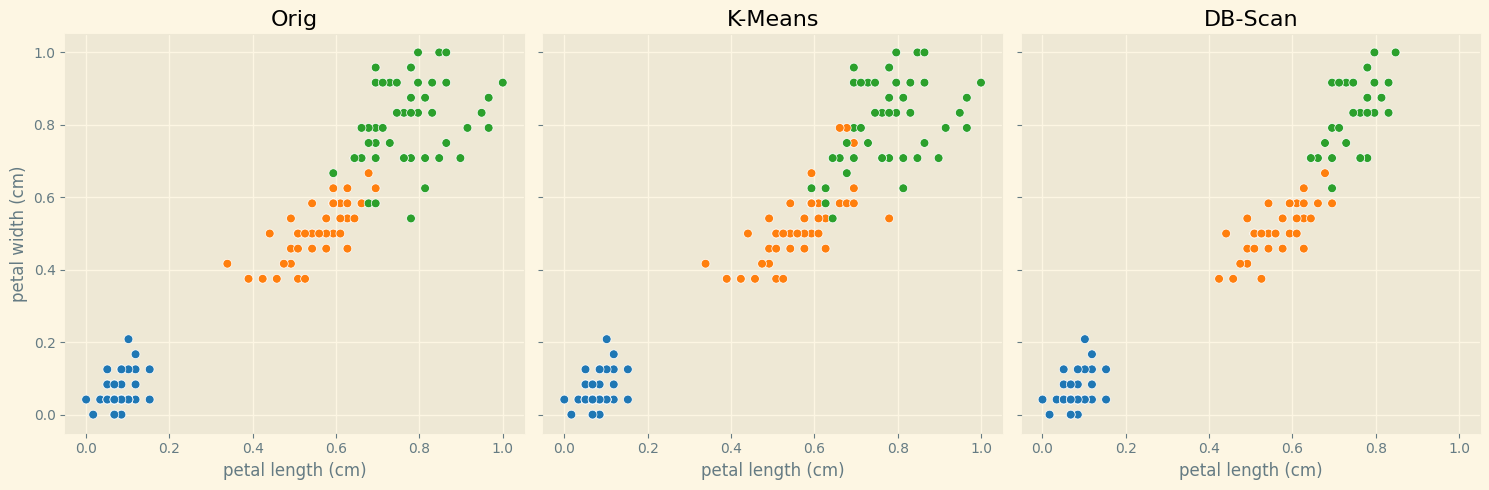

In [ ]:
# Prepare data for plotting
labels_list = [y_true, k_means_labels, y_pred_db_scan]
titles = ["Orig", "K-Means", "DB-Scan"]

# Call the function
plot_subplots(df_norm, labels_list, titles, x_col, y_col)

# Confusion Matrix

Off-diagonal values are misclassifications

In [ ]:
def heatmap(cm_k_means, cm_db_scan):
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Width increases for better spacing

    # First subplot: K-Means
    sns.heatmap(cm_k_means, annot=True, fmt='d', cmap='RdPu', ax=axes[0])
    axes[0].set_xlabel('Predicted Cluster')
    axes[0].set_ylabel('True Cluster')
    axes[0].set_title('K-Means')

    # Second subplot: DBScan
    sns.heatmap(cm_db_scan[:k + 1, :], annot=True, fmt='d', cmap='RdPu', ax=axes[1])
    axes[1].set_xlabel('Predicted Cluster')
    axes[1].set_ylabel('True Cluster')
    axes[1].set_title('DB-Scan')

    plt.tight_layout()
    plt.show()

In [ ]:
def confusion_matrix_heatmap(k_means_preds, db_scan_preds, y_true_db_scan):
  # Build confusion matrix
  cm_k_means = confusion_matrix(y_true, k_means_preds)
  cm_db_scan = confusion_matrix(y_true_db_scan, db_scan_preds)

  heatmap(cm_k_means, cm_db_scan)

  return (cm_k_means, cm_db_scan)

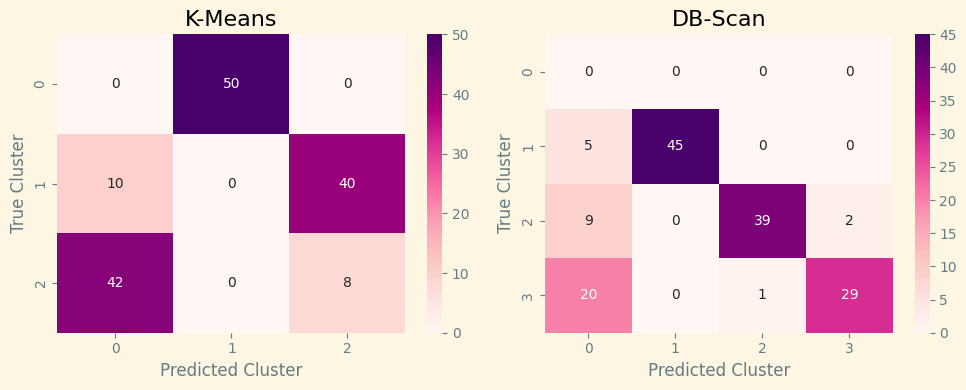

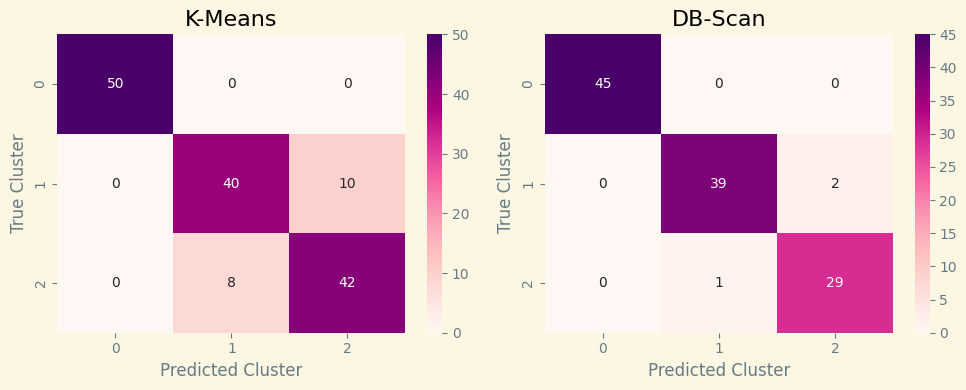

In [ ]:
# not map
cm_k_means_not_mapped, cm_db_scan_not_mapped = confusion_matrix_heatmap(y_pred_k_means, y_pred_db_scan, y_true)
# simple map
# cm_k_means_simple_map, cm_db_scan_simple_map = reorder_confusion_matrix(cm_k_means_not_mapped), reorder_confusion_matrix(cm_db_scan_not_mapped)
# heatmap(cm_k_means_simple_map, cm_db_scan_simple_map[:, :k+1])
# mode map
cm_k_means, cm_db_scan = confusion_matrix_heatmap(k_means_labels, db_scan_labels, dbscan_core_true)

# Accuracy
* Accuracy compares predicted label vs. true label for each sample (Direct match required)
* Used in supervised classification
* The accuracy is n%, meaning the model correctly predicted n% of all samples.


In [ ]:
def calculate_accuracy(confusion_matrix):
    """
    Calculate accuracy from the confusion matrix.
    Accuracy is the ratio of correct predictions to total samples.

    Args:
    confusion_matrix (np.array): The confusion matrix.

    Returns:
    float: Accuracy value.
    """
    # Total correct predictions are the sum of the diagonal elements
    correct_predictions = np.trace(confusion_matrix)

    # Total samples is the sum of all elements in the confusion matrix
    total_samples = np.sum(confusion_matrix)

    # Calculate accuracy
    accuracy = correct_predictions / total_samples
    return accuracy

In [ ]:
km_accuracy = calculate_accuracy(cm_k_means)
print(f"K-Means Accuracy: {km_accuracy:.2%}")

db_accuracy = calculate_accuracy(cm_db_scan)
print(f"DB-Scan Accuracy (excluding noise): {db_accuracy:.2%}")

K-Means Accuracy: 88.00%
DB-Scan Accuracy (excluding noise): 97.41%


# Purity
* Uses majority vote per cluster
* Fetch maximum value from each predict row and add them up and divide the result by the total number of observations
* Purity is a clustering evaluation metric.

In [ ]:
def cal_purity(confusion_mat, name: str) -> None:
    rows_max_sum = 0
    for row in confusion_mat.T:
        rows_max_sum += max(row) # row -> predicted col

    print(f"{name} purity is {rows_max_sum / np.sum(confusion_mat):.2%}")

In [ ]:
cal_purity(cm_k_means_not_mapped, "Iris K-Mean")
cal_purity(cm_db_scan_not_mapped[:, 1:], "Iris DB-Scan")

Iris K-Mean purity is 88.00%
Iris DB-Scan purity is 97.41%


# Accuracy vs Purity
Using not mapped cm

In [ ]:
km_accuracy = calculate_accuracy(cm_k_means_not_mapped)
print(f"K-Means Accuracy: {km_accuracy:.2%}")

cal_purity(cm_k_means_not_mapped, "Iris K-Mean")

K-Means Accuracy: 5.33%
Iris K-Mean purity is 88.00%


# Precision
Precision = True Positives / (True Positives + False Positives)

n% of the samples predicted as cluster m were actually m.

using predicted columns

In [ ]:
def cal_precision(confusion_mat, name: str):
    precisions = []
    print(f"\n{name} - standard precision")
    cm = np.array(confusion_mat)
    for i in range(cm.shape[0]):
        col = cm[:, i]
        if np.sum(col) == 0:
            precisions.append(0)
            continue
        precision = cm[i][i] / np.sum(col)
        precisions.append(precision)
        print(f"Cluster {i} precision: {precision:.2%}")

    return precisions

In [ ]:
k_mean_precisions = cal_precision(cm_k_means, "Iris K-Mean")
db_scan_precisions = cal_precision(cm_db_scan, "Iris DB-Scan")


Iris K-Mean - standard precision
Cluster 0 precision: 100.00%
Cluster 1 precision: 83.33%
Cluster 2 precision: 80.77%

Iris DB-Scan - standard precision
Cluster 0 precision: 100.00%
Cluster 1 precision: 97.50%
Cluster 2 precision: 93.55%


## Weighted Precision
To calculate the weighted average precision, we will multiply the precision of each label and multiply them with their sample size and divide it by the total number of samples we just found

In [ ]:
# each row = sample size
avg_precision_k = np.sum(k_mean_precisions * np.array([np.sum(row) for row in cm_k_means])) / np.sum(cm_k_means)
avg_precision_d = np.sum(db_scan_precisions * np.array([np.sum(row) for row in cm_db_scan])) / np.sum(cm_db_scan)

print(f"Weighted Precision K_Means: {avg_precision_k:.2%}")
print(f"Weighted Precision DB_Scan: {avg_precision_d:.2%}")
print(f"Without Weight Precision DB_Scan: {sum(db_scan_precisions) / len(db_scan_precisions):.2%}")

Weighted Precision K_Means: 88.03%
Weighted Precision DB_Scan: 97.45%
Without Weight Precision DB_Scan: 97.02%


# Recall
### measures how often a machine learning model correctly identifies positive instances (true positives) from all the actual positive samples in the dataset (Quantity)

In [ ]:
def cal_recall(confusion_mat, name: str):
    print(f"\n{name} - recall")
    cm = np.array(confusion_mat)
    for i in range(cm.shape[0]):
        row_sum = np.sum(cm[i, :])
        if row_sum == 0:
            continue
        # precision = cm[i][i] / len((y_true[y_true == i])) # use all true labels include noises
        recall = cm[i][i] / row_sum
        print(f"Cluster {i} recall: {recall:.2%}")

In [ ]:
cal_recall(cm_k_means, "Iris K-Mean")
cal_recall(cm_db_scan, "Iris DB-Scan")


Iris K-Mean - recall
Cluster 0 recall: 100.00%
Cluster 1 recall: 80.00%
Cluster 2 recall: 84.00%

Iris DB-Scan - recall
Cluster 0 recall: 100.00%
Cluster 1 recall: 95.12%
Cluster 2 recall: 96.67%


# F1-Score

In [ ]:
def cal_f1_score(confusion_mat, name: str):
    f1_scores = []
    print(f"\n{name} - f1-scores")
    cm = np.array(confusion_mat)
    for i in range(cm.shape[0]):
        row_sum = np.sum(cm[i, :])
        col_sum = np.sum(cm[:, i])

        if row_sum == 0 or col_sum == 0:
          f1_scores.append(0)
          continue

        recall = cm[i][i] / row_sum
        precision = cm[i][i] / col_sum

        f1 = (2 * recall * precision) / (recall + precision)
        f1_scores.append(f1)
        print(f"Cluster {i} f1 score: {f1:.3}")
    return f1_scores

In [ ]:
f1_scores_k = cal_f1_score(cm_k_means, "Iris K-Mean")
f1_scores_db = cal_f1_score(cm_db_scan, "Iris DB-Scan")


Iris K-Mean - f1-scores
Cluster 0 f1 score: 1.0
Cluster 1 f1 score: 0.816
Cluster 2 f1 score: 0.824

Iris DB-Scan - f1-scores
Cluster 0 f1 score: 1.0
Cluster 1 f1 score: 0.963
Cluster 2 f1 score: 0.951


## Wrighted F1 Score

In [ ]:
# each row = sample size
avg_f1_k = np.sum(f1_scores_k * np.array([np.sum(row) for row in cm_k_means])) / np.sum(cm_k_means)
avg_f1_db = np.sum(f1_scores_db * np.array([np.sum(row) for row in cm_db_scan])) / np.sum(cm_db_scan)

print(f"Weighted f1 score avg K_Means: {avg_f1_k:.2}")
print(f"Weighted f1 score avg DB_Scan: {avg_f1_db:.2}")

Weighted f1 score avg K_Means: 0.88
Weighted f1 score avg DB_Scan: 0.97


# RI 0 to 1

| Property            | Value                                 |
| ------------------- | ------------------------------------- |
| **Range**           | 0 to 1                                |

✅ What a High RI Means:

* Your clustering is mostly consistent with the ground truth.

* Most sample pairs are treated the same way (together/apart) in both clusterings.

## Suppose you have 4 samples: A, B, C, D.

You look at all pairs:

    AB, AC, AD, BC, BD, CD

Compute a, b:

    Diff in true, diff in predicted (b += 1)

    Same in true, same in predicted (a += 1)

RI = (a + b) / len(all_pairs)

In [ ]:
ari_k_means = rand_score(y_true, y_pred_db_scan)
ari_db_scan = rand_score(dbscan_core_true, y_pred_db_scan[y_pred_db_scan != -1])

print(f"RI K-Means: {ari_k_means:.3f}")
print(f"RI DB-Scan: {ari_db_scan:.3f}")

RI K-Means: 0.846
RI DB-Scan: 0.969


# NMI

| Property            | Value                                 |
| ------------------- | ------------------------------------- |
| **Range**           | 0 to 1                                |
| **1.0**             | Perfect match                         |
| **0.0**             | Totally independent                   |


How much information is shared between the predicted and true clusterings.


| Aspect                                   | RI           | NMI                |
| ---------------------------------------- | ------------ | ------------------ |
| Focus                                    | Sample pairs | Information theory |
| Sensitive to class imbalance?            | Yes          | No (more robust)   |
| Handles varying number of clusters well? | Not always   | Yes                |
| Good for measuring overlap in structure  | Moderate     | Excellent          |


In [ ]:
nmi_k_means = normalized_mutual_info_score(y_true, k_means_labels)
nmi_db_scan = normalized_mutual_info_score(dbscan_core_true, db_scan_labels)

print(f"ARI K-Means: {nmi_k_means:.3f}")
print(f"ARI DB-Scan: {nmi_db_scan:.3f}")

ARI K-Means: 0.714
ARI DB-Scan: 0.903


# ETC

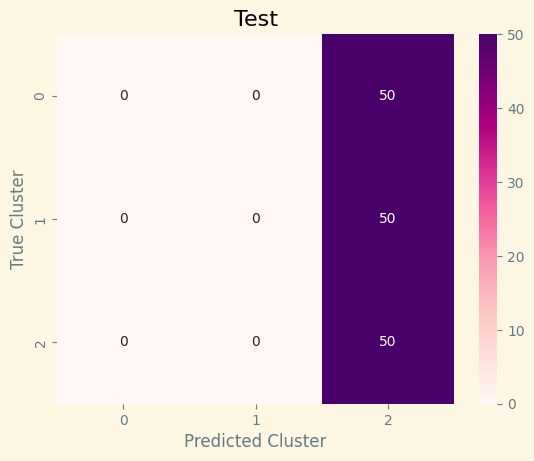

In [ ]:
cm_test = np.array([[0, 0, 50], [0, 0, 50], [0, 0, 50]])

# Test
sns.heatmap(cm_test, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Cluster')
plt.title('Test')
plt.show()

In [ ]:
cal_purity(cm_test, "Test")
print(f"Acc: {calculate_accuracy(cm_test):.2%}")

Test purity is 33.33%
Acc: 33.33%
